# Assignment 1 group 1
Github repo is found at: https://github.com/c-wejendorp/ComSocSciAssignment1Group1
<br>
Contributions: s204090 45% , s204145 10% and s216135 45%


In [1]:
#import the necessary libraries used in this notebook
from bs4 import BeautifulSoup 
import requests
import re
import csv
import pandas as pd
import warnings
import time
import pickle
import os
import gc

doRequests=False


#### Part 1: Using web-scraping to gather data
We are interested in identifying the researchers that have joined the most important scientific conference in Computational Social Science in 2019. To do this we webscrape the programmes from 2019. They can be found at the following links:<br>
- https://2019.ic2s2.org/oral-presentations/
- https://2019.ic2s2.org/posters/

We scraped the websites using the code below:



In [2]:
oralPresenters = set()
#first link
link1="https://2019.ic2s2.org/oral-presentations/"
#get the HTML content
r = requests.get(link1)
#use BeautifulSoup to parse the content. 
soup = BeautifulSoup(r.content)
#locate the HTML tag containing the author names by inspecting the website using at browser.
# We see that the names are located in the tag <p> 
paragraphs=soup.find_all("p")
#relevant paragraphs choosen by quick manual inspection
paragraphs=paragraphs[3:-7]
#we note that each rooom has a "chairperson" which WILL NOT be included. 

for paragraph in paragraphs:
    #print(paragraph)
    text=str(paragraph)
    #spilt by the "<br>"
    text=re.split("<br>|<br/>",text)    
    #locate the names by splitting by "-" and choosing idx 2    
    for line in text[2:]:        
        lineList=re.split(r'\s*\–\s*|\.s*',line)        
        #get each individual name 
        # we check if lineList has a lenght over 1 as sometimes there is no "." btw the authornames and the topic.
        # Instead there is a "–". Thus we do not include the authors where this is the case. 
        if len(lineList)>1:
            
            names=re.split(r',\s*',lineList[2])    
            for name in names:
                oralPresenters.add(name)

print(f"We found {len(oralPresenters)} authors when scraping the oral presentations")     


We found 516 authors when scraping the oral presentations


In [3]:
posterPresenters = set()
#second link
link2= "https://2019.ic2s2.org/posters/"
#get the HTML content
r = requests.get(link2)
#use BeautifulSoup to parse the content. 
soup = BeautifulSoup(r.content)
#we locate the HTML tag <ul> in the soup.
unOrderedLists=soup.find_all("ul")
#locate the HTML tag <li> as the author names are located within these tags. 
lists=soup.find_all("li")
#We did some manual inspection and choose the relevant <li> tags
relevantLists=lists[32:-7]

for num,item in enumerate(relevantLists):    
    text=str(item)   
    # find the text between the first "<li>" and first"<span>"
    #text=re.split(r"\s*<li>|<span>",text,maxsplit=2)
    text=re.split(r"\s*<li>|\s*</li>|<span>",text)
    # for some reason the first element after the split is "" an empty string, so the author names is located at index 1.    
    namesString=text[1]
    #split the names string into individual names. They are seperated by "," and "and". However we must bed carefull not to split name such as as "Alessandro Cossard" into "Aless" and "ro"
    # thereofore we require the char before "and" to be a space. This achieved by: (?<=\s)    
    names=re.split(r"\s*,\s*|(?<=\s)and\s*",namesString) 
    
    for name in names:
        #when we inspected the posterPresenters set, it became clear that some unwanted "names" were added to the set. An example is: "<strong>Evolution of Employment in the United States: A Longitudinal Study of Job Polarisation</strong>"
        #thus we decided to only add a name, if the string doesn't contain any typical html notation such as "<",">" and "/"
        pattern = re.compile(r'[<>/]')
        if pattern.findall(name):
            #uncomment below if you want to see the "names" that contains unwanted characters             
            #print(name)
            pass 
        else: 
            posterPresenters.add(name)            

print(f"We found {len(posterPresenters)} authors when scraping the poster presentations")          
    
    

We found 475 authors when scraping the poster presentations


In [4]:
#unique authors:
uniqueAuthors=oralPresenters|posterPresenters
print(f"We found {len(uniqueAuthors)} unique researchers in 2019") 

#save the names into a csv.
f = open('data/initialNames.csv',"w")
writer = csv.writer(f,lineterminator = '\n')
for name in list(uniqueAuthors):    
    writer.writerow([name])

We found 915 unique researchers in 2019


During the websscraping we were very careful when extracting names from lines of text.
As an example we could not just split a string as "Jacob SomethingCool, Alessandro Cossard and Lars AnotherName"
carelessly by the pattern "," or "and" as this would lead to the names:
["Jacob SomethingCool, Aless, andro Cossard, Lars AnotherName"] and thus ending up overestimating the number of authors. In the case of the 2019 programmes it was fairly easy to perform some manuel checks, to estimate whether the found number of researchers seemed plausable. 



#### Part 2: Getting data from the Semantic Scholar API
In this notebook we will only use the researchers from the conference in 2019. From these 915 conference attendees we end up with 54589 unique IDs when all their collaborators have been found. This is done in the notebook getAuthorIDs.ipynb. 

When working with the Semantic Scholar API it is only possible to do 100 request pr 5 min. However they do include the option to do a batchsearch of up to 100 IDs in a single request. We did utilze this but the API is very prone to errors, so we potentially miss out on information on a lot of authors. To accomdate for this we create a list to store these "bad" responses. For each batch request we create a small dataframe with information about 100 authors and save this into a pkl. This is to limit the size of the files. We then merge all the smaller dataframes into one big one where we extract information needed to create the three smaller dataframes: "Author dataset", "Paper dataset" and "Paper abstract dataset".


In [5]:
#Lets load the IDs of all authors from the csv. 
allAuthorIDs={}
with open('data/allAuthorIDs.csv', 'r') as f:
    for line in csv.reader(f):
        id = line[0]
        name = line[1]
        allAuthorIDs[id]=name 
print(f"The number of total IDs are {len(allAuthorIDs)}")

The number of total IDs are 54589


The cell below DOES NOT NEED TO BE RAN, it only serves as documentation for how we worked with the API

In [6]:
if doRequests==True:
    #we split into appropiate batch sizes and requestsizes. 
    # we can request 100 times pr 5 min and each request can be on 100 names
    numRequests = 100
    batchSize = 100
    sleepTIme= 60*5

    authorList=list(allAuthorIDs.keys())


    authorBatches = [authorList[i:i + batchSize] for i in range(0, len(authorList), batchSize)]
    requestList = [authorBatches[i:i + numRequests] for i in range(0, len(authorBatches),numRequests)]

    BASE_URL = "https://api.semanticscholar.org/graph/"
    VERSION = "v1/"
    RESOURCE = "author/batch"
    my_url = BASE_URL + VERSION + RESOURCE
    params = {
                "fields":"authorId,name,aliases,citationCount,papers,papers.externalIds,papers.title,papers.abstract,papers.year,papers.citationCount,papers.s2FieldsOfStudy,papers.authors"}

    #This is a pandas df that contains all the relevent info, and it will later be split up into the three required. 
    #The pandasDF
    authorDfColumns=["authorId","name","aliases","citationCount","papersId","papersExternalId","papersTitle","papersAbstract","papersYear","papersCitationCount","papers_s2FieldsOfStudy","papersAuthors"]
    authorDF=pd.DataFrame(columns=authorDfColumns)

    # sometimes we get an internal server error, so we would like to save these batches for inspection or something else
    theBadBunch = []

    #pandas is not so fond of this way of appending to a df, so we suppress the warning. 
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=FutureWarning)    
        
        for num,request in enumerate(requestList):
            print(f"I am a request number {num+1} out of {len(requestList)}")
            for batchnum,batch in enumerate(request):        
                json_data={"ids": batch}
                r=requests.post(my_url,json=json_data,params = params)

                statuscode = r.reason
                #print(statuscode)
                if statuscode == "OK": 
                    batchauthorDF = authorDF.copy()        
                    #try:                  
                    for person in r.json():
                        if person is not None:
                        #check if we recieved usefull information
                            if person.get("authorId") is not None:                

                                authorDetails = {
                                "authorId": person["authorId"],      
                                "name":  person["name"],
                                "aliases": person["aliases"],
                                "citationCount": person["citationCount"]}
                                #check if the author have written some papers
                                if person.get("papers") is not None:
                                    papers = person["papers"]
                                    #update the authorDetails dict by the update operator: "|="            
                                    authorDetails |= {                
                                    "papersId": [paper['paperId'] for paper in papers],            
                                    "papersExternalId": [paper['externalIds'] for paper in papers],                       
                                    "papersTitle": [paper['title'] for paper in papers],  
                                    "papersAbstract": [paper['abstract'] for paper in papers], 
                                    "papersYear": [paper['year'] for paper in papers], 
                                    "papersCitationCount": [paper['citationCount'] for paper in papers], 
                                    "papers_s2FieldsOfStudy": [paper['s2FieldsOfStudy'] for paper in papers], 
                                    "papersAuthor": [paper['authors'] for paper in papers], 
                                                                                            }
                                #lets add relevant information to our df
                                batchauthorDF = batchauthorDF.append(authorDetails, ignore_index=True)
                                pickleName = f"data/syltedeAgurker/agurk{num},{batchnum}.pkl"
                                batchauthorDF.to_pickle(pickleName)
                                    
                            else:
                                print("Bad response from API, unable to use. THis is the json:")
                                print(f"This should be the person {person}")
                                print("And this is the json")
                                print(r.json())    
                    #except:
                        #print("I had an error..")
                        

                else: 
                    theBadBunch.append((statuscode,batch))
            print("I am going to sleep")        
            time.sleep(sleepTIme)
            print("I woke up")     

    #we save all the list with the author IDs, which did return a bad response from the API; such as 'Internal Server Error'. 
    with open("data/theBadBunch.pkl", 'wb') as file:
        pickle.dump(theBadBunch, file)
    print(f'We have failed to retrieve data for {len(theBadBunch)*100} authors, due to errors when requesting')
    print("These author IDs are now stored in theBadBunch.pkl if want to do something about this")

In the github repo we have provided the pickles needed to create the dataframe below. Thus one can continue executing cells from here. In the cell below we create one big DF that we will use to create the three smaller. 


In [7]:
#just iterate over all syltede agurker ^^
directory = 'data/syltedeAgurker' 
# iterate over files in
# that in the directory
pandaListen = []
for agurk in os.listdir(directory):
    agurkLokation = os.path.join(directory, agurk)
    # checking if it is a file
    if os.path.isfile(agurkLokation):
        unpickled_df=pd.read_pickle(agurkLokation) 
        pandaListen.append(unpickled_df)

df_big = pd.concat(pandaListen, ignore_index=True) 
print(f"After we have completed all the batchrequest, we were left with {len(df_big)} out of {len(allAuthorIDs)} IDs")
print(f"This is not optimal, but one could potentially try doing single ID request as we have stored the IDs in the file 'theBadBunch'.pkl")

After we have completed all the batchrequest, we were left with 22375 out of 54589 IDs
This is not optimal, but one could potentially try doing single ID request as we have stored the IDs in the file 'theBadBunch'.pkl


In [8]:
#lets create the three dataframes requested:
# first the authorDataSet dataframe

authorDataSet=df_big[["authorId","name","aliases","citationCount","papers_s2FieldsOfStudy"]].copy()

authorDataSet["fields"]=[[dictionary["category"] for sublist in author for dictionary in sublist] for author in authorDataSet["papers_s2FieldsOfStudy"]]

authorDataSet["mainField"]=authorDataSet["fields"].apply(lambda lst: max(set(lst), key=lst.count,default="None"))

authorDataSetFinal=authorDataSet[["authorId","name","aliases","citationCount","mainField"]].copy()

authorDataSetFinal.rename(columns = {'mainField':'field'}, inplace = True)
authorDataSetFinal.to_pickle("data/authorDataSet.pkl")
print(f"The lenght of the final Author dataframe is: {len(authorDataSetFinal)}")

The lenght of the final Author dataframe is: 22375


In [9]:
#remove the authorDataSetFinal df from memory.
del [[authorDataSetFinal]]
gc.collect()
authorDataSetFinal = pd.DataFrame()

In [10]:
# now the two paper dataframes.
#We start by creating a big paper df. 
columnNames=["papersId","papersTitle","papersYear","papersExternalId","papersCitationCount","papers_s2FieldsOfStudy","papersAuthor","papersAbstract"]

bigPaperDataSet=df_big[columnNames].copy()
#The dataframe is now such that reach row correspond to a single author. This means that an entry in "papersId" is actually a list with the different paper IDs.
# Thus we create a new df by zipping the lists in each row. 
# We then add each paper to a paperDF by iterating over the zip.  
# this is done in the next cell.

#to free some memory we delete the df_big, as we dont need it anymore. 
del [[df_big]]
gc.collect()
df_big = pd.DataFrame()

In [11]:
dictionaryList=[]
 
for index, row in bigPaperDataSet.iterrows():
    rowinformation=[row[column] for column in columnNames]
    zipped=zip(*rowinformation)    
    for paper in zipped:
        paperdictionary = dict(zip(columnNames, paper))
        dictionaryList.append(paperdictionary)

bigPaperDataSet = pd.DataFrame.from_dict(dictionaryList)

In [12]:
#now we extract information from the bigPaperDataSet to creat the two last dataframes:

PaperDataSet=bigPaperDataSet[["papersId","papersTitle","papersYear","papersExternalId","papersCitationCount","papers_s2FieldsOfStudy","papersAuthor"]]
PaperDataSet.to_pickle("data/paperDataSet.pkl")

PaperAbstractDataSet=bigPaperDataSet[["papersId","papersAbstract"]]
PaperAbstractDataSet.to_pickle("data/paperAbstractDataSet.pkl")

print(f"The lenght of the final paper dataframe is: {len(PaperDataSet)}")

The lenght of the final paper dataframe is: 1125521


Part 2 summary.

We started by using the 54589 unique IDs which came from the 2019 conference speakers and their collaborators.
This number was then reduced to 22375 due to a failure prone API. The ones we could not retrieve data on is saved such that they can be requested if needed at a later time. 

The final lenght of the author dataframe is: 22375
The final lenght of the paper dataframe is: 1125521

In [13]:
#remove all dataframes from memory
del [[bigPaperDataSet,PaperAbstractDataSet]]
gc.collect()
bigPaperDataSet = pd.DataFrame()
PaperAbstractDataSet = pd.DataFrame()


# Exercise 3: Law of large numbers
## Normal distribution

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import random
np.random.seed(2)
random.seed(2)

In [30]:
num_samples = 10_000

X = np.arange(0, num_samples) # ranges used for plotting
X_ = np.arange(1, num_samples+1, 1_000)

def analyze_sample(Y):  
    """Returns all relevant stats for a sample Y."""
    n = len(Y)
  
    # 3-4) Cumulative average and standard error
    cum_avg = [np.mean(Y[:i]) for i in range(1, n+1)]
    cum_SE = [np.std(Y[:i]) / np.sqrt(i) for i in range(1, n+1)]

    # 5) mean and median
    mean, median = np.mean(Y), np.median(Y)
    
    # 7) Cumulative median
    cum_med = [np.median(Y[:i]) for i in range(1, n+1)]

    return cum_avg, cum_SE, cum_med, mean, median

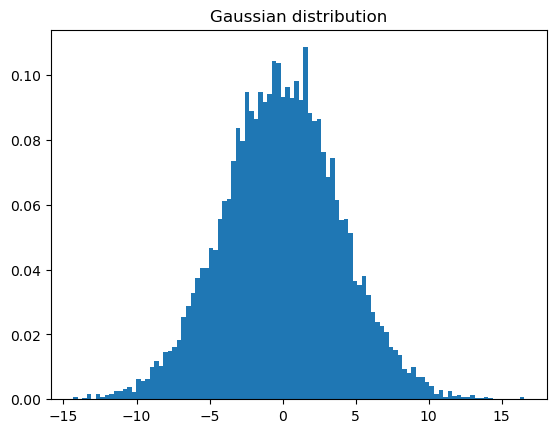

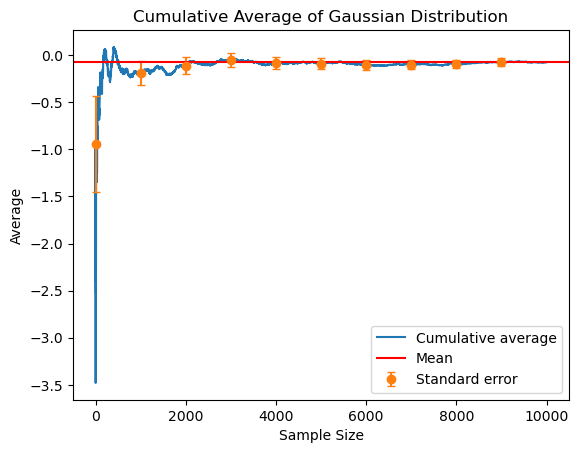

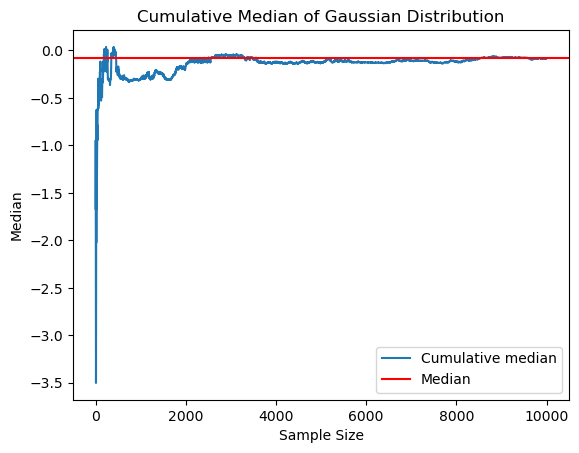

In [31]:
# 1) Gaussian sampling
mu, sigma = 0, 4
Y = np.random.standard_normal(num_samples) * sigma + mu
cum_avg, cum_SE, cum_med, mean, median = analyze_sample(Y)

# 2) Plot distribution
plt.hist(Y, bins=100, density=True)
plt.title('Gaussian distribution')
plt.show()

# 6) Plot cumulative average and standard error
plt.title('Cumulative Average of Gaussian Distribution')
plt.xlabel('Sample Size'); plt.ylabel('Average')
# X = np.arange(0, num_samples)
plt.plot(X, cum_avg, label='Cumulative average')

# X_ = np.arange(1, num_samples+1, 1_000)  # Error bar - Only plot every 1000th point for ease of viewing
cum_avg = [cum_avg[x] for x in X_]
cum_SE = [cum_SE[x] for x in X_]
plt.errorbar(X_, cum_avg, yerr=cum_SE, fmt='o', capsize=3, label='Standard error')
plt.axhline(mean, color='r', label='Mean')
plt.legend()
plt.show()

# 8) Plot cumulative median and distribution median
plt.title('Cumulative Median of Gaussian Distribution')
plt.xlabel('Sample Size'); plt.ylabel('Median')
plt.plot(X, cum_med, label='Cumulative median')
plt.axhline(median, color='r', label='Median')
plt.legend()
plt.show()

## Pareto distribution

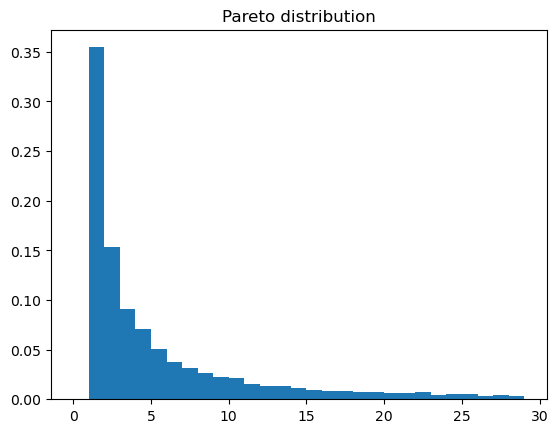

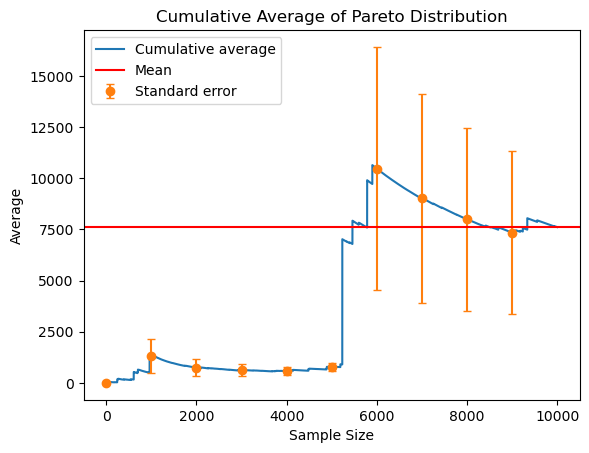

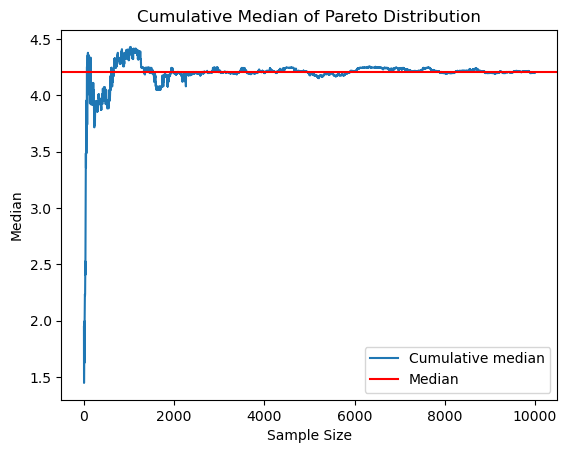

In [32]:
# 9) Pareto sampling
x_m = 1 # scale x_m/m parameter
alpha = 0.5 # shape alpha/a parameter
Y = (np.random.pareto(alpha, num_samples) + 1) * x_m
cum_avg, cum_SE, cum_med, mean, median = analyze_sample(Y)

# 2) Plot distribution
plt.hist(Y, bins=np.arange(0, 30, 1), density=True)
plt.title('Pareto distribution')
plt.show()

# 6) Plot cumulative average
plt.title('Cumulative Average of Pareto Distribution')
plt.xlabel('Sample Size'); plt.ylabel('Average')
plt.plot(X, cum_avg, label='Cumulative average')  # LEARNING MOMENT max(cum_avg) return 300000, which afterwards drops towards zero

cum_avg = [cum_avg[x] for x in X_]  # Error bars
cum_SE = [cum_SE[x] for x in X_]
plt.errorbar(X_, cum_avg, yerr=cum_SE, fmt='o', capsize=3, label='Standard error')
plt.axhline(mean, color='r', label='Mean')
plt.legend()
plt.show()

# 7) Plot cumulative median
plt.title('Cumulative Median of Pareto Distribution')
plt.xlabel('Sample Size'); plt.ylabel('Median')
plt.plot(X, cum_med, label='Cumulative median')
plt.axhline(median, color='r', label='Median')
plt.legend()
plt.show()

## Lognormal Distribution

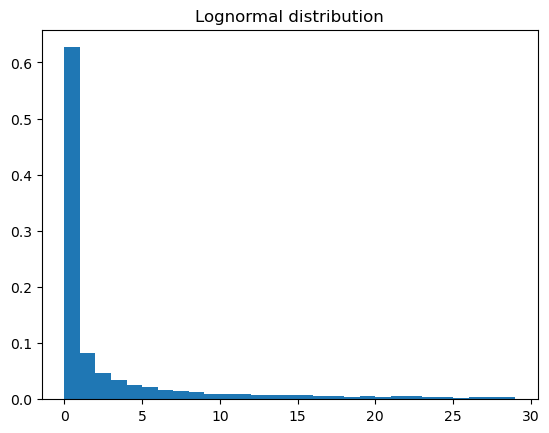

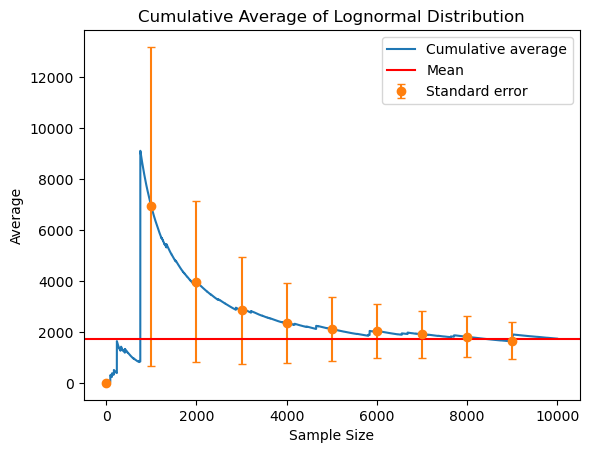

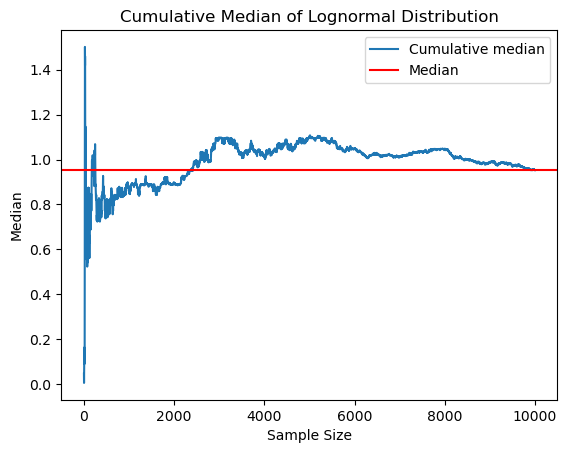

In [33]:
# 11) Pareto sampling by inverse transform sampling of uniform distribution
mu = 0 
sigma = 4 
Y = np.exp(np.random.standard_normal(num_samples) * sigma + mu)
cum_avg, cum_SE, cum_med, mean, median = analyze_sample(Y)

# 2) Plot distribution
plt.hist(Y, bins=np.arange(0, 30, 1), density=True)
plt.title('Lognormal distribution')
plt.show()

# 6) Plot cumulative average
plt.title('Cumulative Average of Lognormal Distribution')
plt.xlabel('Sample Size'); plt.ylabel('Average')
plt.plot(X, cum_avg, label='Cumulative average')

cum_avg = [cum_avg[x] for x in X_]  # Error bars
cum_SE = [cum_SE[x] for x in X_]
plt.errorbar(X_, cum_avg, yerr=cum_SE, fmt='o', capsize=3, label='Standard error')
plt.axhline(mean, color='r', label='Mean')
plt.legend()
plt.show()

# 7) Plot cumulative median
plt.title('Cumulative Median of Lognormal Distribution')
plt.xlabel('Sample Size'); plt.ylabel('Median')
plt.plot(X, cum_med, label='Cumulative median')
plt.axhline(median, color='r', label='Median')
plt.legend()
plt.show()

## Citations from 2019

In [34]:


citation_count = list(PaperDataSet['papersCitationCount'].values)

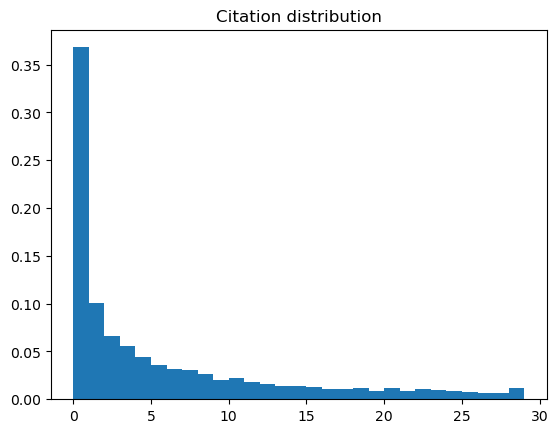

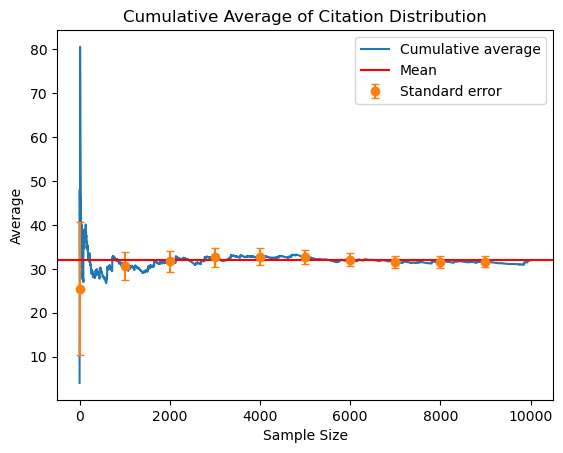

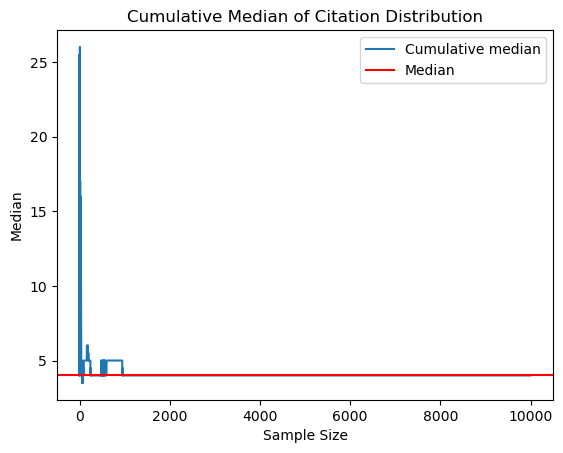

In [35]:
Y = random.sample(citation_count, num_samples)
cum_avg, cum_SE, cum_med, mean, median = analyze_sample(Y)

# 2) Plot distribution
plt.hist(Y, bins=np.arange(0, 30, 1), density=True)
plt.title('Citation distribution')
plt.show()

# 6) Plot cumulative average
plt.title('Cumulative Average of Citation Distribution')
plt.xlabel('Sample Size'); plt.ylabel('Average')
plt.plot(X, cum_avg, label='Cumulative average')

cum_avg = [cum_avg[x] for x in X_]  # Error bars
cum_SE = [cum_SE[x] for x in X_]
plt.errorbar(X_, cum_avg, yerr=cum_SE, fmt='o', capsize=3, label='Standard error')
plt.axhline(mean, color='r', label='Mean')
plt.legend()
plt.show()

# 7) Plot cumulative median
plt.title('Cumulative Median of Citation Distribution')
plt.xlabel('Sample Size'); plt.ylabel('Median')
plt.plot(X, cum_med, label='Cumulative median')
plt.axhline(median, color='r', label='Median')
plt.legend()
plt.show()

Compare the evolution of the cumulative average for the Gaussian, Pareto and LogNormal distribution. What do you observe? Would you expect these results? Why?
- Gaussian is not heavy tailed, so follows the Law of Large Numbers. Pareto has crazy outliers, due to the 80/20 rule of which it was defined from. It is defined to be heavy tailed. Thus a single outlier can have a huge impact on the cumulative mean. The same applies to Lognormal, as plots behave similar. This could be due to the exponential increasing the impact of outliers.

Compare the cumulative median vs the cumulative average for the three distributions. What do you observe? Can you draw any conclusions regarding which statistics (the mean or the median) is more usfeul in the different cases?
- In general median is more robust to outliers. Thus, median is most usefull in heavy tailed distributions. 

Consider the plots you made using the citation count data in point 14. What do you observe? What are the implications?
- The distribution is heavy tailed, and thus the mean is not a good representation of the data. The median is more usefull.

What do you think are the main take-home message of this exercise?
- Papers citations are apparently heavy tailed. Heavy tailed distributions are not well represented by the mean, and thus median is more usefull. 